# ***Customer Segmentation Project***

1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime

*Notebook display settings*

In [ ]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

2. Load Dataset

In [ ]:
df = pd.read_csv("/content/data.csv", encoding='latin1')
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (238351, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


3. Basic Info

In [ ]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238351 entries, 0 to 238350
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    238351 non-null  object 
 1   StockCode    238351 non-null  object 
 2   Description  237453 non-null  object 
 3   Quantity     238350 non-null  float64
 4   InvoiceDate  238350 non-null  object 
 5   UnitPrice    238350 non-null  float64
 6   CustomerID   171623 non-null  float64
 7   Country      238350 non-null  object 
dtypes: float64(3), object(5)
memory usage: 14.5+ MB
None


4. Data Cleaning

In [ ]:
# Drop missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove negative or zero quantities/prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create TotalAmount column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

print("\nAfter Cleaning:", df.shape)
df.head()


After Cleaning: (167521, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


5. RFM Metrics Calculation

In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalAmount': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
print("\nRFM Table Sample:")
rfm.head()



RFM Table Sample:


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,157,1,77183.60
12347.0,15,102,2205.95
12348.0,80,28,1487.24
12350.0,141,17,334.40
12352.0,93,38,1561.81


6. Scaling Features

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

7. Find Optimal Clusters (Elbow Method)

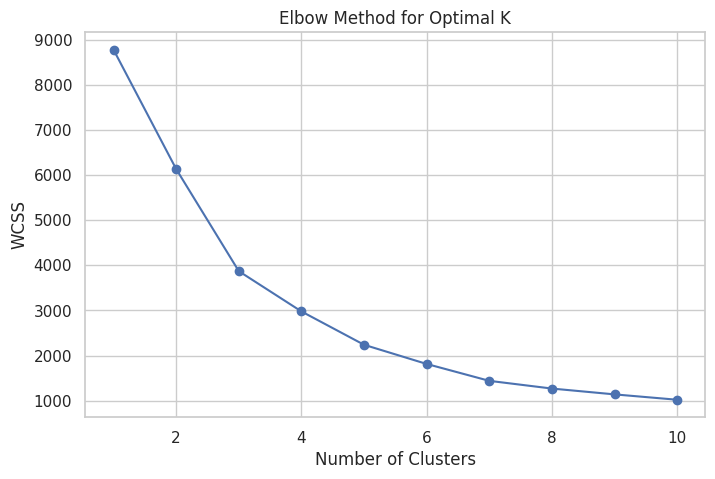

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
k = 4  # You can adjust based on elbow curve
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
print("\nClustered RFM Table:")
rfm.head()


Clustered RFM Table:


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,157,1,77183.60,2
12347.0,15,102,2205.95,0
12348.0,80,28,1487.24,0
12350.0,141,17,334.40,1
12352.0,93,38,1561.81,1


9. Cluster Summary

In [ ]:
cluster_summary = rfm.groupby('Cluster').mean()
print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
            Recency    Frequency      Monetary
Cluster                                       
0         33.463950    65.699582   1315.093820
1        139.946411    25.164813    437.648220
2         25.250000   280.750000  59747.588333
3          5.100000  1351.500000  20116.821000


10. Visualize Clusters

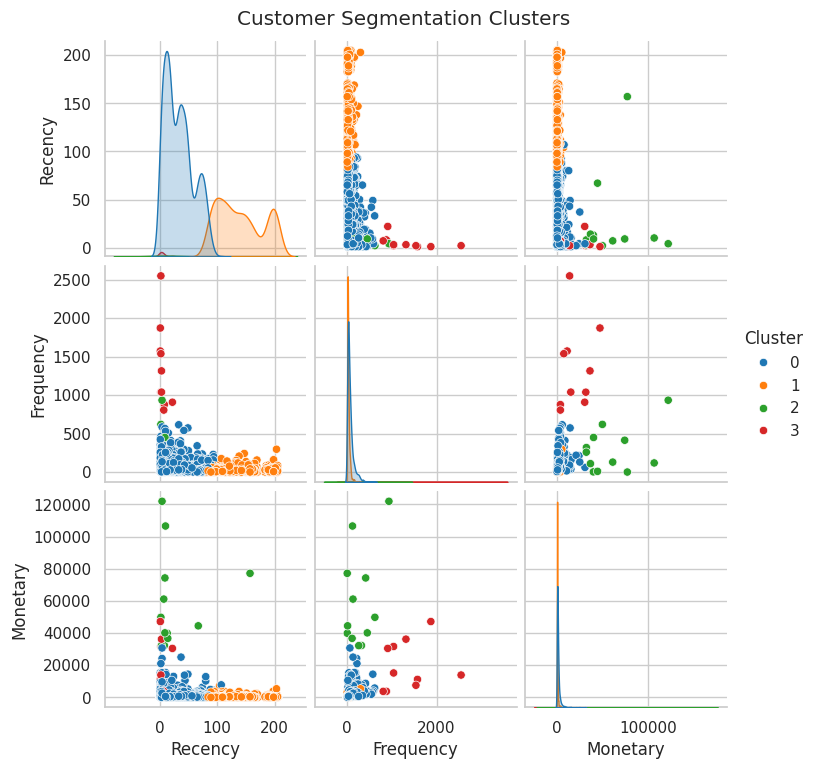

In [ ]:
# Scatter plots for pairwise relations
sns.pairplot(rfm.reset_index(), hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'], palette='tab10')
plt.suptitle('Customer Segmentation Clusters', y=1.02)
plt.show()

11. Save Processed RFM Table

In [ ]:
rfm.to_csv("/content/rfm_clusters.csv", index=True)
print("\nProcessed RFM data with clusters saved as rfm_clusters.csv")


Processed RFM data with clusters saved as rfm_clusters.csv
